In [1]:
import os
os.chdir("/home/hamza-arain/Documents/code/HumanActiityTrack")

In [2]:
# >>> data_transformation.py

from sklearn.decomposition import PCA
from scipy.signal import butter, lfilter, filtfilt
import copy
import pandas as pd

# This class removes the high frequency data (that might be considered noise) from the data.
# We can only apply this when we do not have missing values (i.e. NaN).
class LowPassFilter:
    def low_pass_filter(
        self,
        data_table,
        col,
        sampling_frequency,
        cutoff_frequency,
        order=5,
        phase_shift=True,
    ):
        # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
        # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
        nyq = 0.5 * sampling_frequency
        cut = cutoff_frequency / nyq

        b, a = butter(order, cut, btype="low", output="ba", analog=False)
        if phase_shift:
            data_table[col + "_lowpass"] = filtfilt(b, a, data_table[col])
        else:
            data_table[col + "_lowpass"] = lfilter(b, a, data_table[col])
        return data_table


# Class for Principal Component Analysis. We can only apply this when we do not have missing values (i.e. NaN).
# For this we have to impute these first, be aware of this.
class PrincipalComponentAnalysis:
    pca = []
    def __init__(self):
        self.pca = []

    def normalize_dataset(self, data_table, columns):
        dt_norm = copy.deepcopy(data_table)
        for col in columns:
            dt_norm[col] = (data_table[col] - data_table[col].mean()) / (
                data_table[col].max()
                - data_table[col].min()
                # data_table[col].std()
            )
        return dt_norm

    # Perform the PCA on the selected columns and return the explained variance.
    def determine_pc_explained_variance(self, data_table, cols):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=len(cols))
        self.pca.fit(dt_norm[cols])
        # And return the explained variances.
        return self.pca.explained_variance_ratio_

    # Apply a PCA given the number of components we have selected.
    # We add new pca columns.
    def apply_pca(self, data_table, cols, number_comp):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=number_comp)
        self.pca.fit(dt_norm[cols])

        # Transform our old values.
        new_values = self.pca.transform(dt_norm[cols])

        # And add the new ones:
        for comp in range(0, number_comp):
            data_table["pca_" + str(comp + 1)] = new_values[:, comp]

        return data_table

In [3]:
# >>> frequency_abstraction.py

import numpy as np

# This class performs a Fourier transformation on the data to find frequencies that occur
# often and filter noise.
class FourierTransformation:

    # Find the amplitudes of the different frequencies using a fast fourier transformation. Here,
    # the sampling rate expresses the number of samples per second (i.e. Frequency is Hertz of the dataset).
    def find_fft_transformation(self, data, sampling_rate):
        # Create the transformation, this includes the amplitudes of both the real
        # and imaginary part.
        transformation = np.fft.rfft(data, len(data))
        return transformation.real, transformation.imag

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, cols, window_size, sampling_rate):

        # Create new columns for the frequency data.
        freqs = np.round((np.fft.rfftfreq(int(window_size)) * sampling_rate), 3)

        for col in cols:
            data_table[col + "_max_freq"] = np.nan
            data_table[col + "_freq_weighted"] = np.nan
            data_table[col + "_pse"] = np.nan
            for freq in freqs:
                data_table[
                    col + "_freq_" + str(freq) + "_Hz_ws_" + str(window_size)
                ] = np.nan

        # Pass over the dataset (we cannot compute it when we do not have enough history)
        # and compute the values.
        for i in range(window_size, len(data_table.index)):
            for col in cols:
                real_ampl, imag_ampl = self.find_fft_transformation(
                    data_table[col].iloc[
                        i - window_size : min(i + 1, len(data_table.index))
                    ],
                    sampling_rate,
                )
                # We only look at the real part in this implementation.
                for j in range(0, len(freqs)):
                    data_table.loc[
                        i, col + "_freq_" + str(freqs[j]) + "_Hz_ws_" + str(window_size)
                    ] = real_ampl[j]
                # And select the dominant frequency. We only consider the positive frequencies for now.

                data_table.loc[i, col + "_max_freq"] = freqs[
                    np.argmax(real_ampl[0 : len(real_ampl)])
                ]
                data_table.loc[i, col + "_freq_weighted"] = float(
                    np.sum(freqs * real_ampl)
                ) / np.sum(real_ampl)
                PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
                PSD_pdf = np.divide(PSD, np.sum(PSD))
                data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)

        return data_table

In [4]:
# >>> temporal_abstraction.py

import numpy as np
import scipy.stats as stats

# Class to abstract a history of numerical values we can use as an attribute.
class NumericalAbstraction:
    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std')
    def aggregate_value(self, aggregation_function):
        # Compute the values and return the result.
        if aggregation_function == "mean":
            return np.mean
        elif aggregation_function == "max":
            return np.max
        elif aggregation_function == "min":
            return np.min
        elif aggregation_function == "median":
            return np.median
        elif aggregation_function == "std":
            return np.std
        else:
            return np.nan

    # Abstract numerical columns specified given a window size (i.e. the number of time points from
    # the past considered) and an aggregation function.
    def abstract_numerical(self, data_table, cols, window_size, aggregation_function):
        # Create new columns for the temporal data, pass over the dataset and compute values
        for col in cols:
            data_table[
                col + "_temp_" + aggregation_function + "_ws_" + str(window_size)
            ] = (
                data_table[col]
                .rolling(window_size)
                .apply(self.aggregate_value(aggregation_function))
            )

        return data_table

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [6]:
# Load data

df = joblib.load("data/02_outliers_removed_chauvenets.joblib")
predictor_columns = list(df.columns[:6])

print(predictor_columns)

df 

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,53.0
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,53.0
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,53.0
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,53.0
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,53.0
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,93.0
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,93.0
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,93.0


## Dealing with missing values (imputation)

<Axes: xlabel='epoch (ms)'>

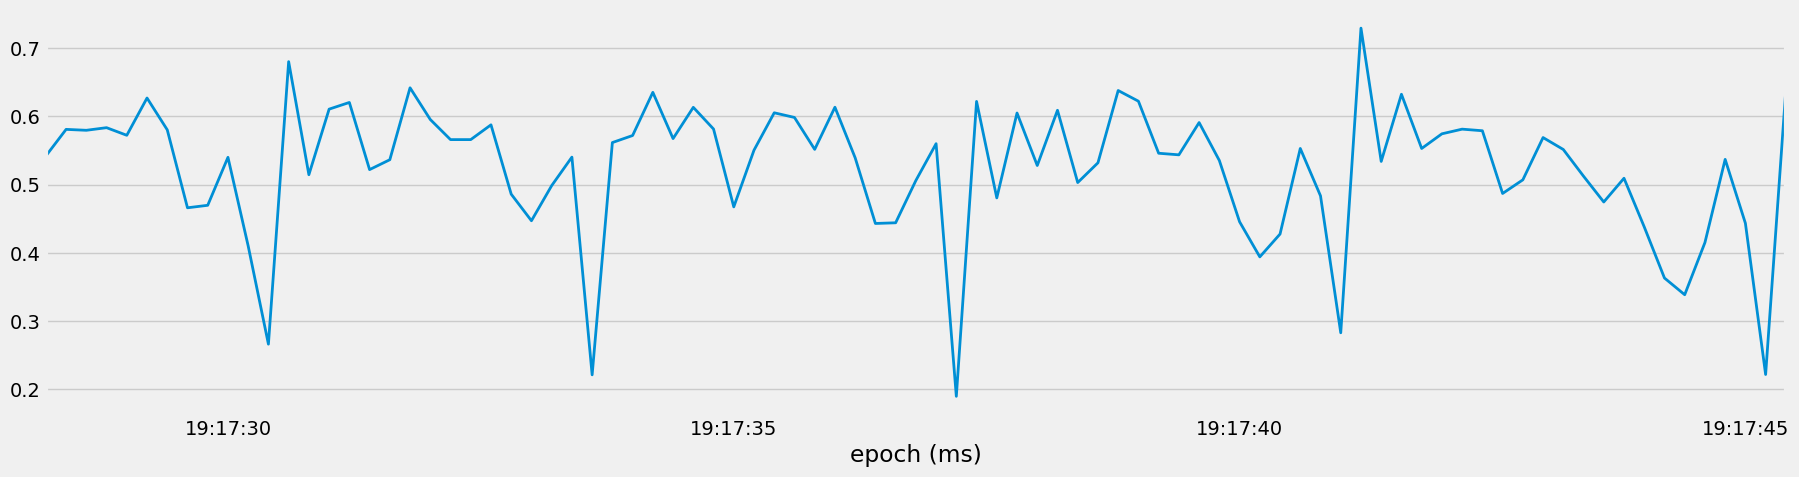

In [7]:
df[df['set']==25]['acc_y'].plot()

In [8]:
print(df.info())

for col in predictor_columns:
    df[col] = df[col].interpolate()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   float64
dtypes: float64(7), object(3)
memory usage: 774.2+ KB
None


<Axes: xlabel='epoch (ms)'>

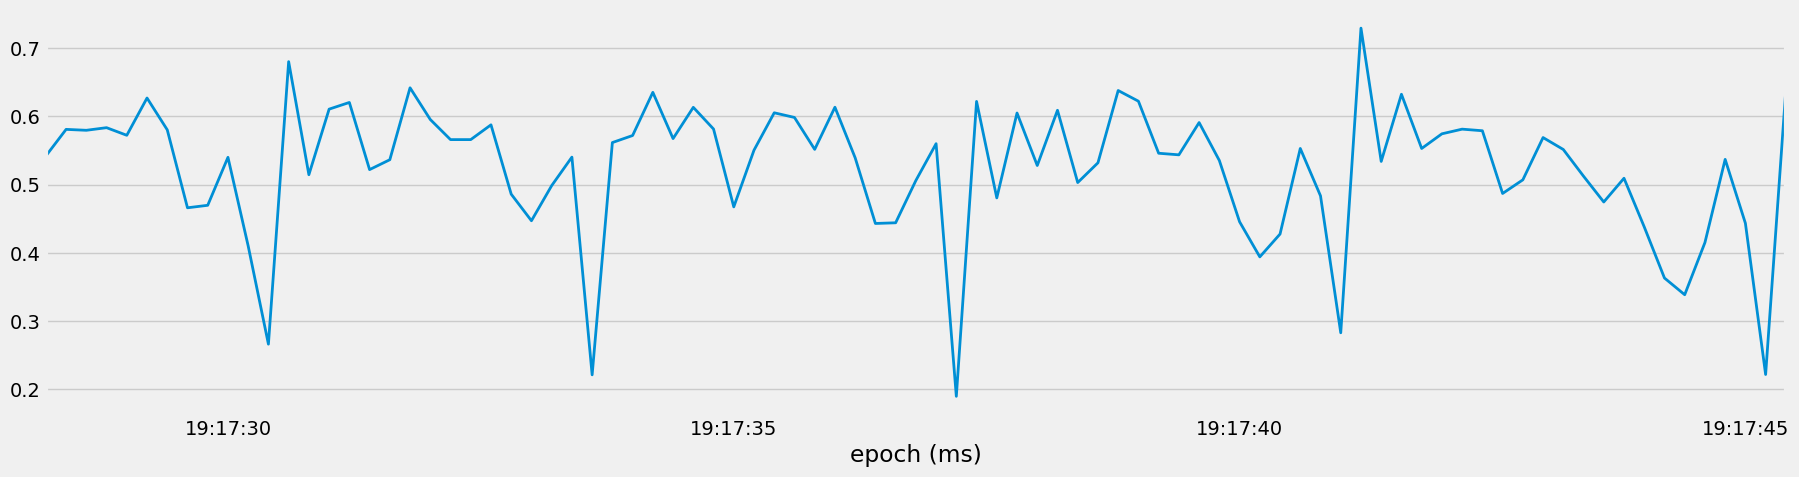

In [9]:
df[df['set']==25]['acc_y'].plot()

## Calculating set duration


In [10]:
# # Difference of 1 set and  previous set
# duration = df[df["set"] == 1].index[-1] - df[df["set"] == 1].index[0]
# duration.seconds # 24 seconds

# # Difference of 1 set and  previous set through loop
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,53.0,16.0
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,53.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,93.0,19.0
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,93.0,19.0
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,93.0,19.0


In [11]:
duration_df = df.groupby(["category"])["duration"].mean()

print(duration_df.iloc[0] / 5)   # no. of 5 reps in a set is 2.98s
print(duration_df.iloc[1] / 10)  # no. of 10 reps in a set is 2.49s

duration_df

2.9487001733102254
2.4942528735632186


category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

## Butterworth lowpass filter


bench


/tmp/ipykernel_34628/691395449.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(subset["label"][0])


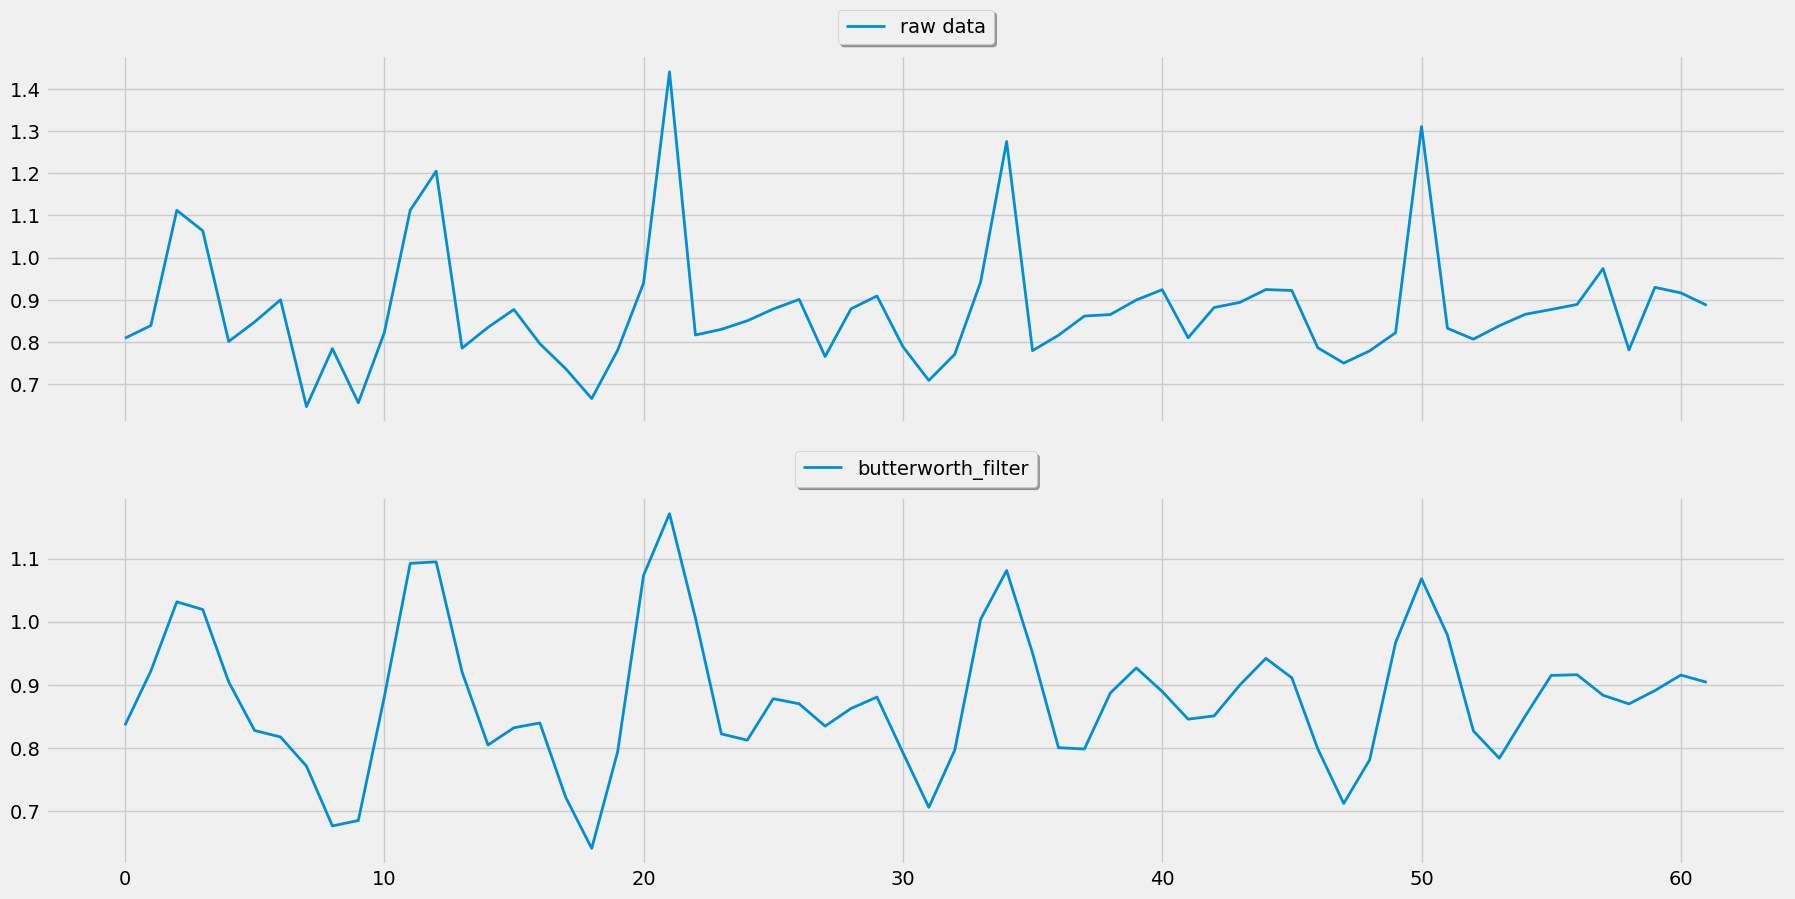

In [12]:

df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 1000/200
cutoff = 1.2

df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label = "raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label = "butterworth_filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

In [13]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,53.0,16.0
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,53.0,16.0
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,53.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,93.0,19.0
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,93.0,19.0
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,93.0,19.0


## Principal component analysis PCA


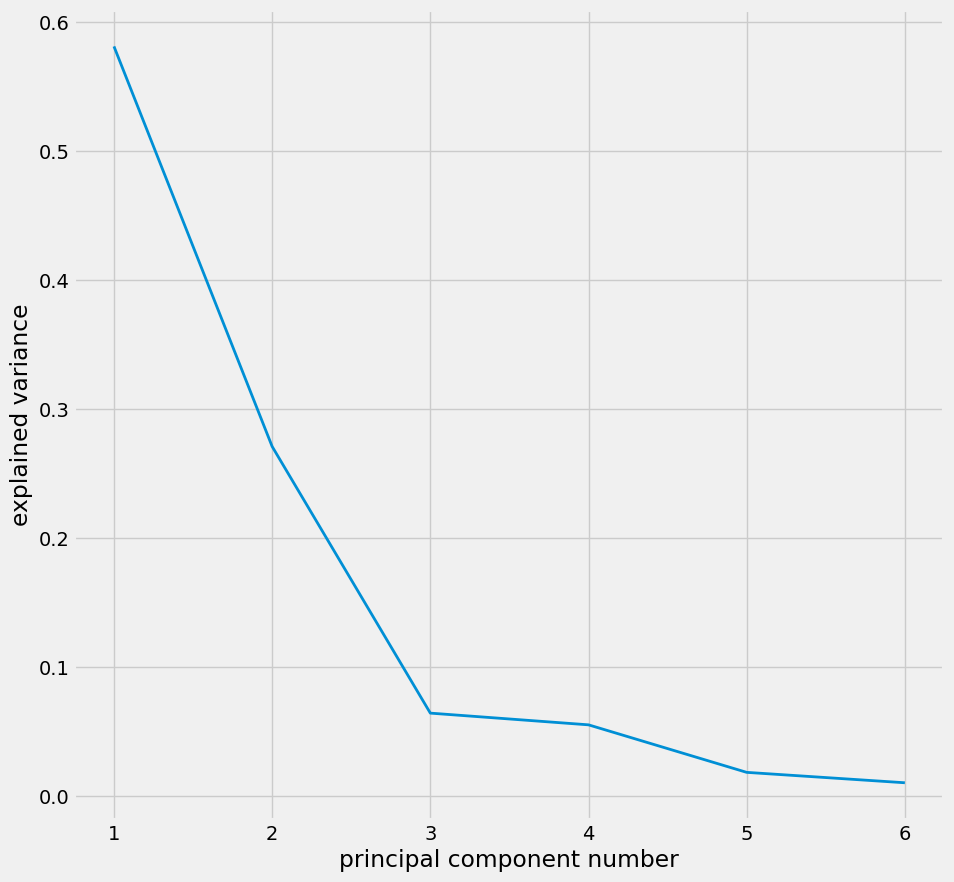

In [14]:
df_pca = df_lowpass.copy()
pca = PrincipalComponentAnalysis()

pc_values = pca.determine_pc_explained_variance(df_pca, predictor_columns)

plt.figure(figsize=(10,10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("principal component number")
plt.ylabel("explained variance")
plt.show()


<Axes: xlabel='epoch (ms)'>

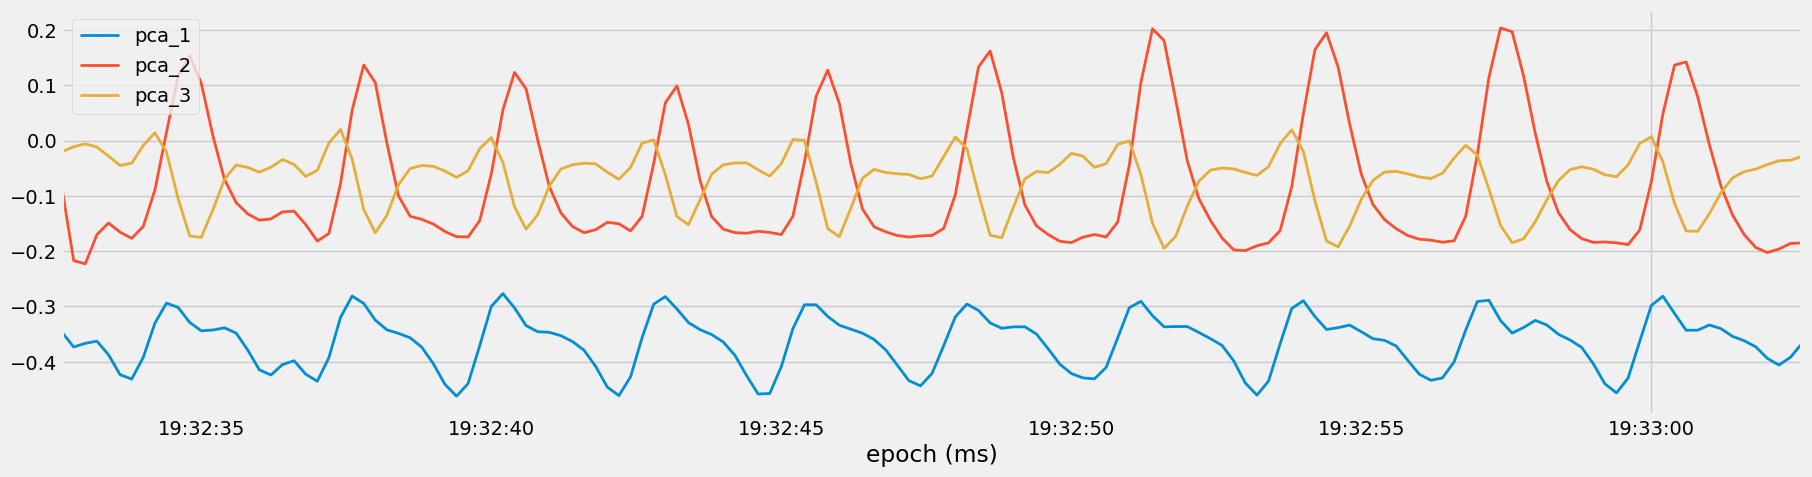

In [15]:
df_pca = pca.apply_pca(df_pca, predictor_columns, 3)

subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()

In [16]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,53.0,16.0,0.317491,-0.075816,0.070520
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,53.0,16.0,0.315555,-0.075282,0.070565
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,53.0,16.0,0.314780,-0.081915,0.065980
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,53.0,16.0,0.316880,-0.090205,0.060065
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,53.0,16.0,0.317350,-0.095463,0.063173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,93.0,19.0,-0.346775,-0.147540,-0.051285
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,93.0,19.0,-0.362725,-0.146231,-0.059154
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,93.0,19.0,-0.372734,-0.153069,-0.058939


## Sum of squares attributes

/home/hamza-arain/Documents/code/HumanActiityTrack/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hamza-arain/Documents/code/HumanActiityTrack/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

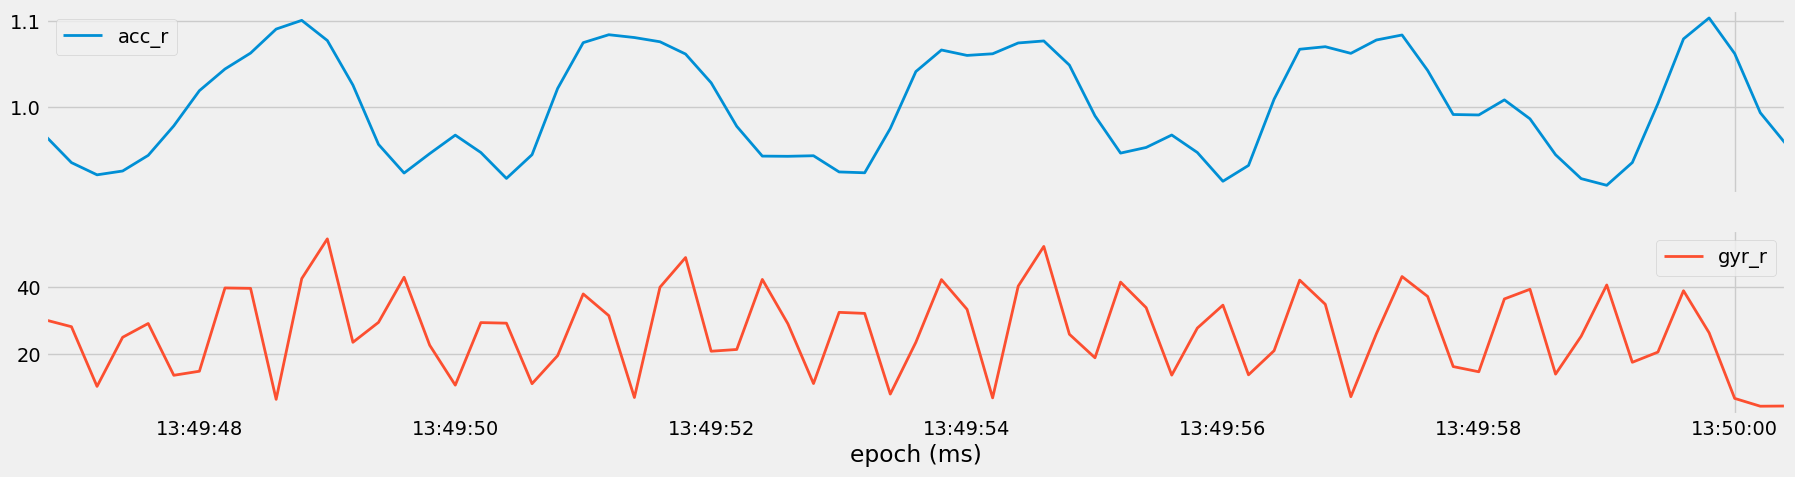

In [17]:
df_squared = df_pca.copy()

acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_squared["set"] == 14]

subset[["acc_r", "gyr_r"]].plot(subplots=True)

In [18]:
df_squared

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,53.0,16.0,0.317491,-0.075816,0.070520,0.991072,2.630261
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,53.0,16.0,0.315555,-0.075282,0.070565,0.987353,2.573340
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,53.0,16.0,0.314780,-0.081915,0.065980,0.984417,4.001395
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,53.0,16.0,0.316880,-0.090205,0.060065,0.986398,1.205182
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,53.0,16.0,0.317350,-0.095463,0.063173,0.987917,2.230693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,93.0,19.0,-0.346775,-0.147540,-0.051285,NaN,2.499318
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,93.0,19.0,-0.362725,-0.146231,-0.059154,NaN,2.334536
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,93.0,19.0,-0.372734,-0.153069,-0.058939,NaN,0.280672


<Axes: xlabel='epoch (ms)'>

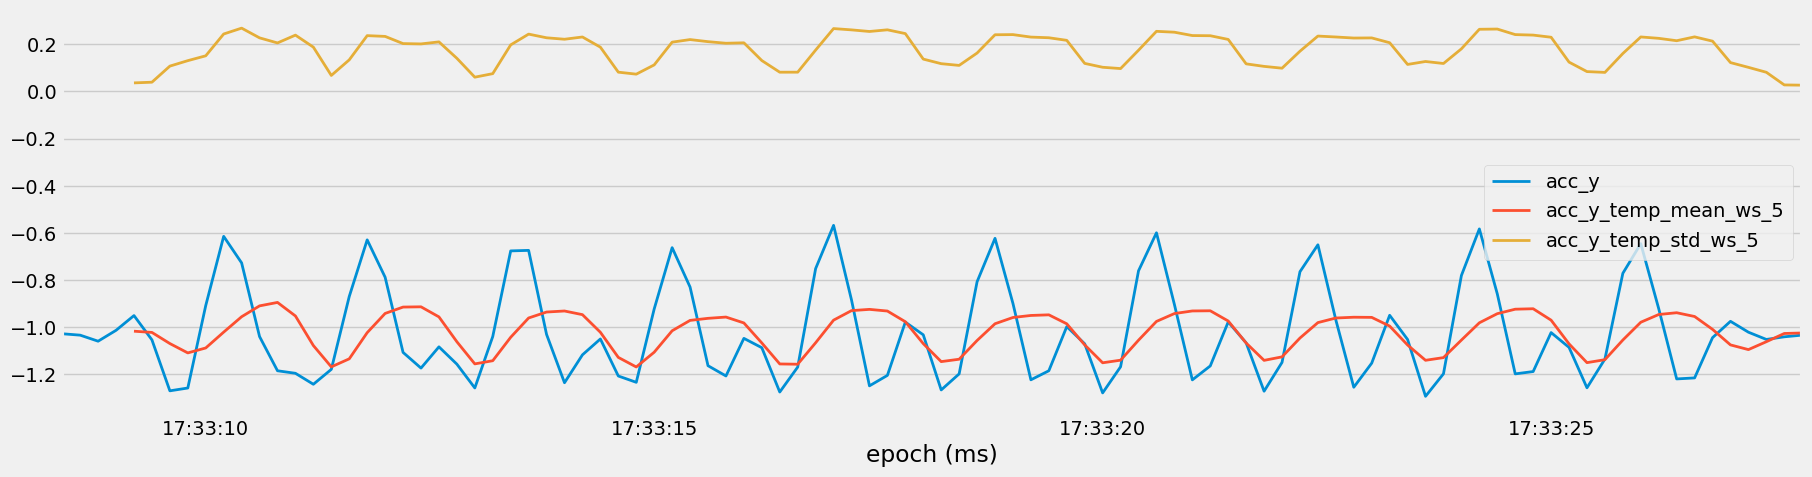

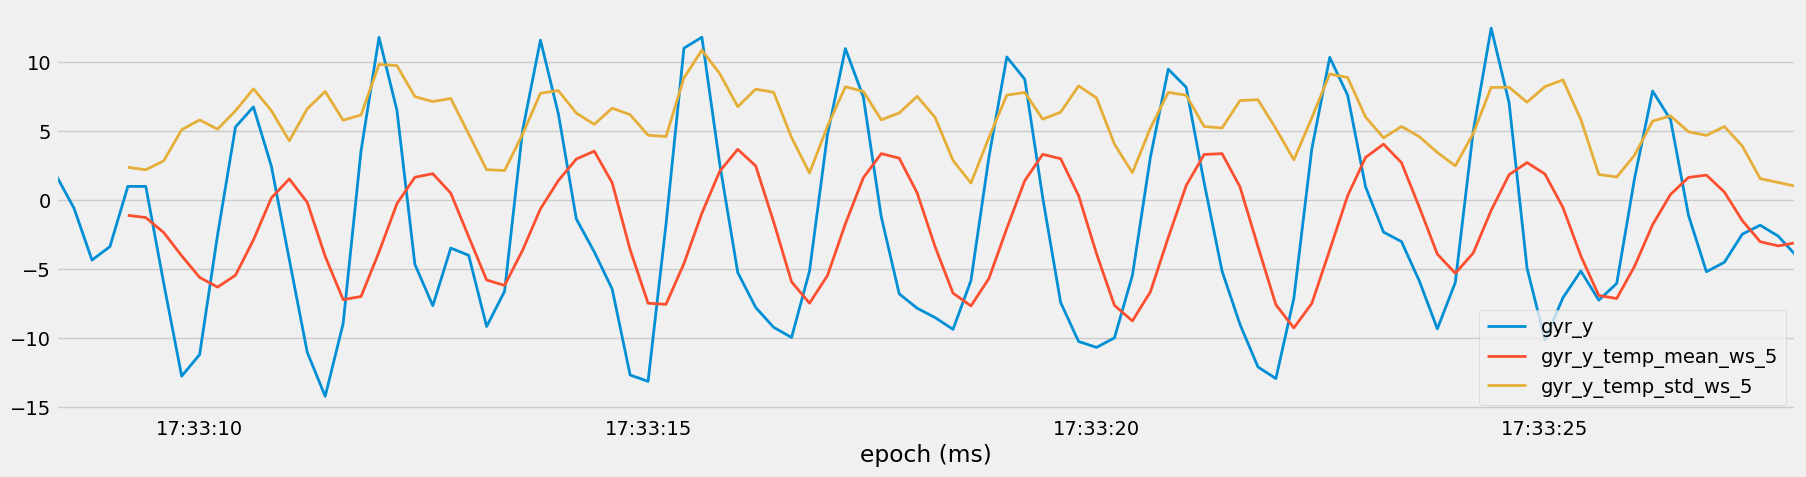

In [19]:
# Temporal abstraction

df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]  # ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_r', 'gyr_r']

ws = int(1000/200)
for col in predictor_columns:
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

In [20]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,53.0,...,1.500334,1.975086,-0.794137,2.101951,-0.523681,1.250569,0.987431,0.002175,2.528174,0.896844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,93.0,...,-11.816937,17.831662,0.603702,5.346850,7.165439,6.227556,NaN,NaN,17.923375,15.069521
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,93.0,...,-4.923778,12.693305,-1.469373,3.932028,4.409868,5.078760,NaN,NaN,10.386622,11.011495
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,93.0,...,0.697498,4.394449,-2.997093,1.570800,1.931172,2.207628,NaN,NaN,4.059230,2.987690


## Frequency features


In [21]:
class FourierTransformation:
    # Find the amplitudes of the different frequencies using a fast fourier transformation. Here,
    # the sampling rate expresses the number of samples per second (i.e. Frequency is Hertz of the dataset).
    def find_fft_transformation(self, data, sampling_rate):
        # Create the transformation, this includes the amplitudes of both the real
        # and imaginary part.
        transformation = np.fft.rfft(data, len(data))
        return transformation.real, transformation.imag

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, cols, window_size, sampling_rate):

        # Create new columns for the frequency data.
        freqs = np.round((np.fft.rfftfreq(int(window_size)) * sampling_rate), 3)

        for col in cols:
            data_table[col + "_max_freq"] = np.nan
            data_table[col + "_freq_weighted"] = np.nan
            data_table[col + "_pse"] = np.nan
            for freq in freqs:
                data_table[
                    col + "_freq_" + str(freq) + "_Hz_ws_" + str(window_size)
                ] = np.nan

        # Pass over the dataset (we cannot compute it when we do not have enough history)
        # and compute the values.
        for i in range(window_size, len(data_table.index)):
            for col in cols:
                real_ampl, imag_ampl = self.find_fft_transformation(
                    data_table[col].iloc[
                        i - window_size : min(i + 1, len(data_table.index))
                    ],
                    sampling_rate,
                )
                # We only look at the real part in this implementation.
                for j in range(0, len(freqs)):
                    data_table.loc[
                        i, col + "_freq_" + str(freqs[j]) + "_Hz_ws_" + str(window_size)
                    ] = real_ampl[j]
                # And select the dominant frequency. We only consider the positive frequencies for now.

                data_table.loc[i, col + "_max_freq"] = freqs[
                    np.argmax(real_ampl[0 : len(real_ampl)])
                ]

                # print(freqs)
                if len(freqs) == 3:
                    freqs = np.append(freqs, .4)
                    print("Length of freqs:", len(freqs), "Length of real_ampl:", len(real_ampl))

                data_table.loc[i, col + "_freq_weighted"] = float(
                    np.sum(freqs * real_ampl)
                ) / np.sum(real_ampl)
                PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
                PSD_pdf = np.divide(PSD, np.sum(PSD))
                data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)

        return data_table



df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = int (1000/200)
ws = int (1000/200)

df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)
df_freq

Length of freqs: 4 Length of real_ampl: 4


,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5,acc_y_max_freq,acc_y_freq_weighted,acc_y_pse,acc_y_freq_0.0_Hz_ws_5,acc_y_freq_1.0_Hz_ws_5,acc_y_freq_2.0_Hz_ws_5,acc_y_freq_0.4_Hz_ws_5
0,2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,...,0.002175,2.528174,0.896844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,...,NaN,17.923375,15.069521,1.0,-0.262674,0.097996,-6.019389,0.752850,0.219406,0.202344
9005,2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,...,NaN,10.386622,11.011495,2.0,-0.113311,0.019551,-6.394882,0.097479,0.249470,0.173150
9006,2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,...,NaN,4.059230,2.987690,2.0,0.060304,0.019882,-6.525232,-0.345052,-0.028208,-0.042800
9007,2019-01-20 17:33:27.600,-0.049361,-1.040440,-0.066542,2.411744,-2.591221,0.659428,E,row,medium,...,NaN,2.917489,2.450592,0.4,0.092611,0.019977,-6.346581,-0.222855,-0.180238,-0.135852


In [22]:
df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'duration', 'pca_1', 'pca_2',
       'pca_3', 'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5',
       'acc_x_temp_std_ws_5', 'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5',
       'acc_z_temp_mean_ws_5', 'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5',
       'gyr_x_temp_std_ws_5', 'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5',
       'gyr_z_temp_mean_ws_5', 'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5',
       'acc_r_temp_std_ws_5', 'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5',
       'acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_5', 'acc_y_freq_1.0_Hz_ws_5',
       'acc_y_freq_2.0_Hz_ws_5', 'acc_y_freq_0.4_Hz_ws_5'],
      dtype='object')

<Axes: >

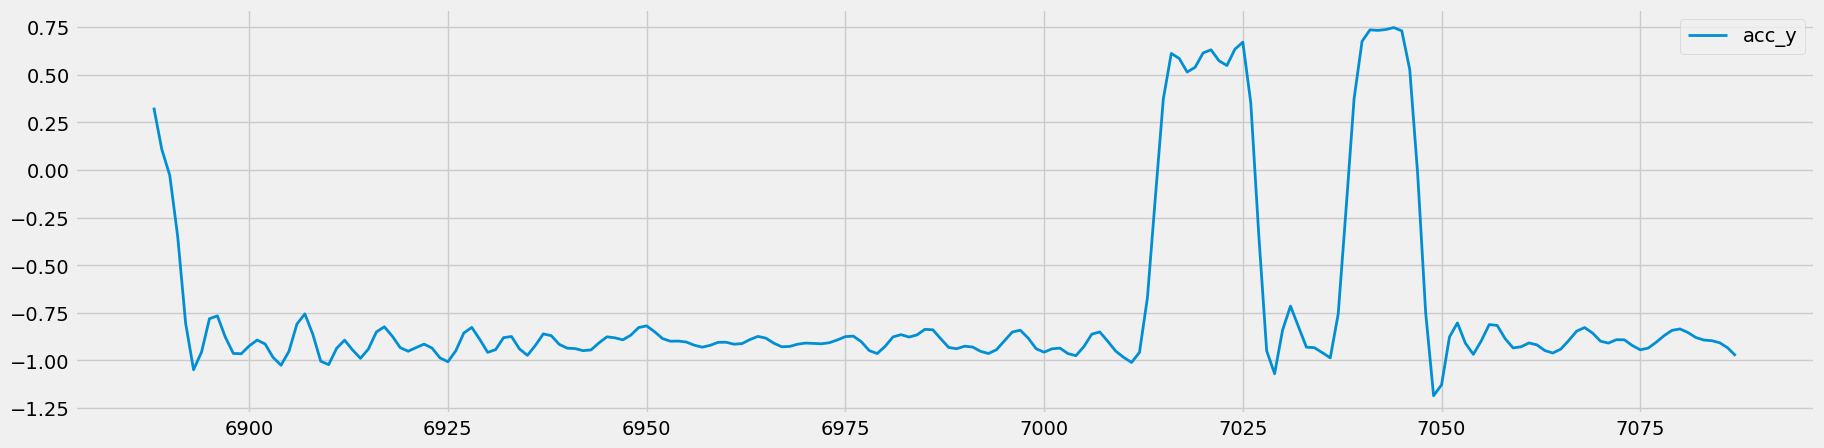

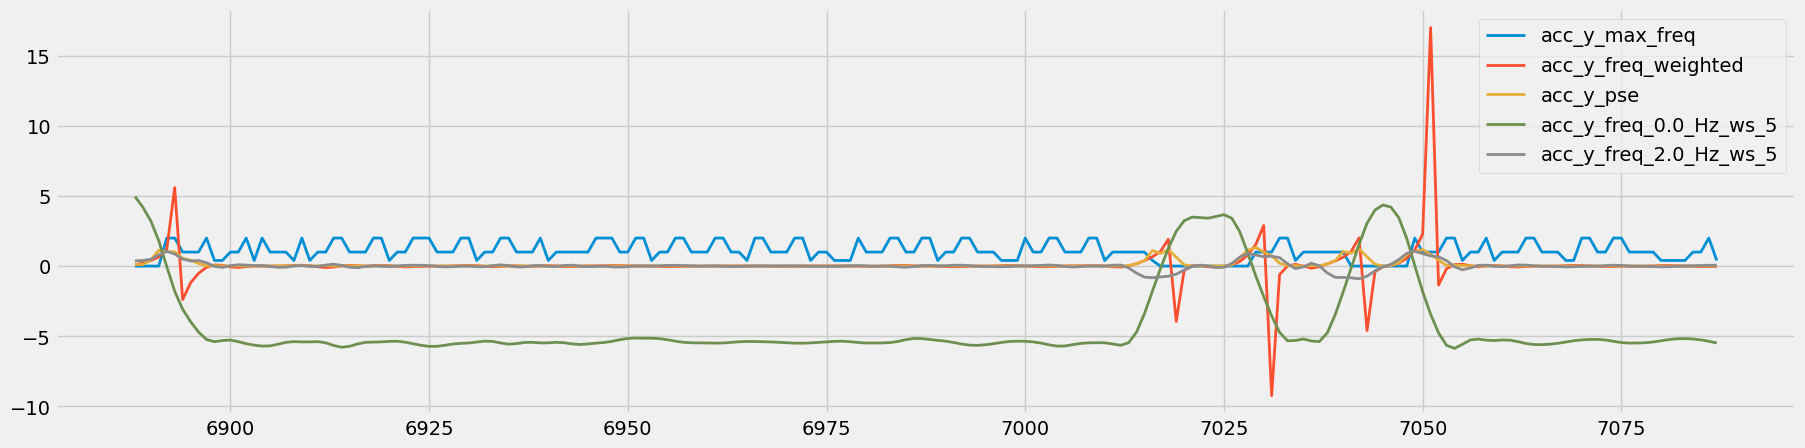

In [23]:
# Visualize Results
subset = df_freq[df_freq["set"] == 15]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_0.0_Hz_ws_5",
        "acc_y_freq_2.0_Hz_ws_5"
    ]
].plot()

In [24]:
df_freq["set"].unique()

array([53., 85., 21., 48., 91., 86., 38., 10., 55., 74., 63., 39., 42.,
       81., 78., 46., 41., 80., 88., 90., 72.,  6., 75., 34., 69., 84.,
       28., 65., 29., 33., 82., 43., 47., 52., 37., 30., 64., 70., 20.,
       77., 45., 14., 27., 73., 17., 23., 57., 18.,  4., 61.,  8.,  9.,
       26.,  5., 25., 54., 66., 22., 35., 16., 51., 50., 40., 67., 49.,
       71., 32., 92., 62., 89., 24., 68., 19., 11., 87., 15., 58., 79.,
        2.,  1., 36., 56., 60., 44.,  7., 12.,  3., 31., 76., 13., 93.])

In [28]:
df_freq_list = []
for s in df_freq["set"].unique():
    try:
        print(f"Applying Fourier Transformation to set {s}")
        subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
        subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
        df_freq_list.append(subset)
    except:
        pass
df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_0.0_Hz_ws_5,gyr_r_freq_1.0_Hz_ws_5,gyr_r_freq_2.0_Hz_ws_5,acc_z_freq_0.4_Hz_ws_5,gyr_x_freq_0.4_Hz_ws_5,gyr_y_freq_0.4_Hz_ws_5,gyr_z_freq_0.4_Hz_ws_5,acc_r_freq_0.4_Hz_ws_5,gyr_r_freq_0.4_Hz_ws_5,acc_x_freq_0.4_Hz_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,93.0,...,104.343774,8.625156,-18.648767,0.142387,4.097850,-0.045584,-0.516646,NaN,4.064834,0.059361
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,93.0,...,91.951412,44.524029,25.391408,0.130386,-14.717568,4.126225,5.798799,NaN,8.327528,0.060161
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,93.0,...,52.213781,28.422420,25.518535,0.048381,-21.589247,5.589904,8.040801,NaN,31.410102,0.048653


## Dealing with overlapping windows


In [31]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_0.0_Hz_ws_5,gyr_r_freq_1.0_Hz_ws_5,gyr_r_freq_2.0_Hz_ws_5,acc_z_freq_0.4_Hz_ws_5,gyr_x_freq_0.4_Hz_ws_5,gyr_y_freq_0.4_Hz_ws_5,gyr_z_freq_0.4_Hz_ws_5,acc_r_freq_0.4_Hz_ws_5,gyr_r_freq_0.4_Hz_ws_5,acc_x_freq_0.4_Hz_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:06.400,-0.069090,0.854465,-0.172661,19.366323,8.017378,-23.630128,B,bench,heavy,53.0,...,57.450227,8.704080,-21.519065,0.069549,-11.208485,-3.258034,12.576418,0.031128,-16.380219,0.060036
2019-01-11 15:08:06.800,-0.219266,0.913740,-0.213814,-9.668758,-5.167347,2.598851,B,bench,heavy,53.0,...,81.822489,-42.463882,6.921232,0.054533,13.352570,3.175449,-6.430392,-0.031083,-3.506096,0.108386
2019-01-11 15:08:07.200,-0.185481,1.171386,-0.094891,-2.098496,-3.884052,0.626982,B,bench,heavy,53.0,...,102.467515,0.664244,-11.473339,-0.006008,-5.749669,0.022311,1.526613,-0.055796,19.689565,0.077099
2019-01-11 15:08:07.600,-0.214236,0.971006,-0.197579,17.968302,3.848977,-6.132753,B,bench,heavy,53.0,...,98.864490,10.722487,-16.204383,0.013228,7.832143,3.785809,-14.478440,-0.044421,39.278499,0.064459
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,53.0,...,120.432318,2.103554,3.102862,-0.028449,2.891827,0.515052,-6.456152,0.047568,7.908000,-0.056732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:26:07.200,-0.567730,0.670876,0.083806,-37.875917,-83.685144,78.304124,E,rest,standing,76.0,...,145.189820,13.828323,-38.579240,-0.032086,38.718387,62.274747,-58.150822,0.097073,-66.245347,-0.176082
2019-01-20 17:26:07.600,0.603921,-0.336276,0.616192,-109.276723,-109.509746,192.690044,E,rest,standing,76.0,...,540.629866,-60.626018,-126.665984,-0.312865,50.032875,38.596964,-93.946702,0.169753,-110.456509,-0.867620
2019-01-20 17:26:10.600,0.731864,0.732391,-0.096888,-8.968865,-28.181608,-9.167155,E,rest,standing,76.0,...,439.646286,206.962625,74.765155,0.140128,2.583329,-17.142335,-76.261229,-0.290672,85.052987,0.173752


## Clustering


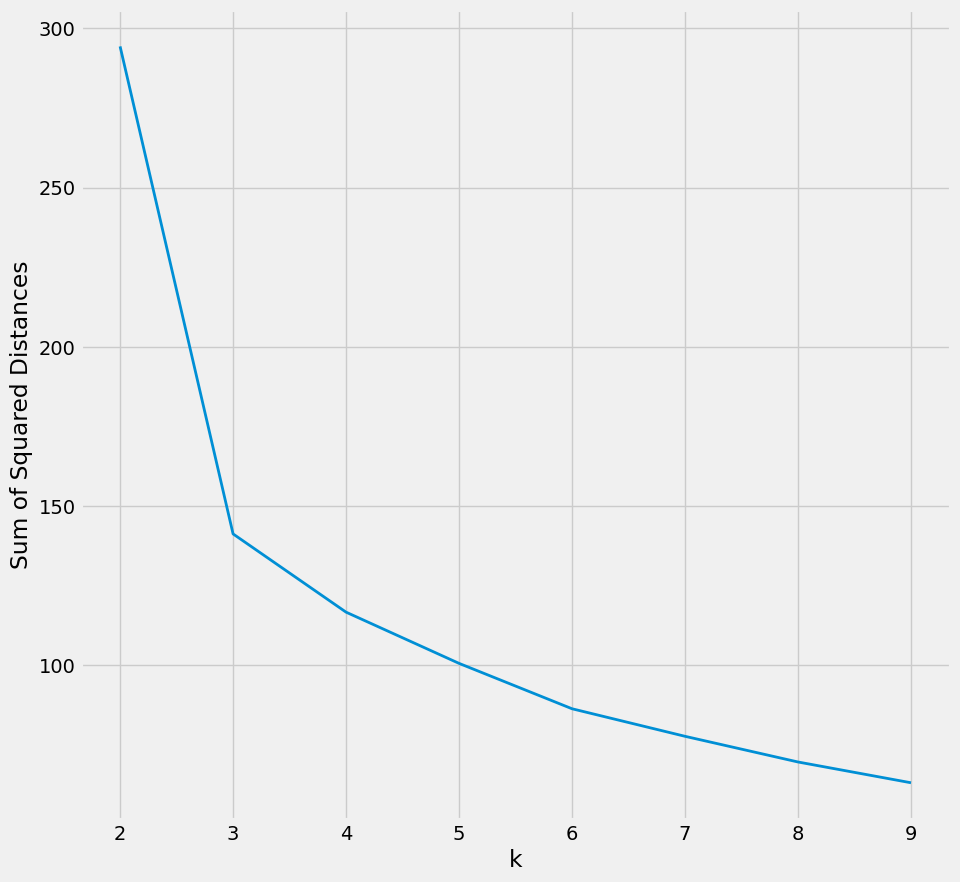

In [38]:
from sklearn.cluster import KMeans

df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2,10)
inertias = []

for k in kvalues:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,10))
plt.plot(k_values, inertias)
plt.xlabel("k")
plt.ylabel("Sum of Squared Distances")
plt.show()

In [39]:
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

In [40]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_1.0_Hz_ws_5,gyr_r_freq_2.0_Hz_ws_5,acc_z_freq_0.4_Hz_ws_5,gyr_x_freq_0.4_Hz_ws_5,gyr_y_freq_0.4_Hz_ws_5,gyr_z_freq_0.4_Hz_ws_5,acc_r_freq_0.4_Hz_ws_5,gyr_r_freq_0.4_Hz_ws_5,acc_x_freq_0.4_Hz_ws_5,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:06.400,-0.069090,0.854465,-0.172661,19.366323,8.017378,-23.630128,B,bench,heavy,53.0,...,8.704080,-21.519065,0.069549,-11.208485,-3.258034,12.576418,0.031128,-16.380219,0.060036,2
2019-01-11 15:08:06.800,-0.219266,0.913740,-0.213814,-9.668758,-5.167347,2.598851,B,bench,heavy,53.0,...,-42.463882,6.921232,0.054533,13.352570,3.175449,-6.430392,-0.031083,-3.506096,0.108386,0
2019-01-11 15:08:07.200,-0.185481,1.171386,-0.094891,-2.098496,-3.884052,0.626982,B,bench,heavy,53.0,...,0.664244,-11.473339,-0.006008,-5.749669,0.022311,1.526613,-0.055796,19.689565,0.077099,2
2019-01-11 15:08:07.600,-0.214236,0.971006,-0.197579,17.968302,3.848977,-6.132753,B,bench,heavy,53.0,...,10.722487,-16.204383,0.013228,7.832143,3.785809,-14.478440,-0.044421,39.278499,0.064459,0
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,53.0,...,2.103554,3.102862,-0.028449,2.891827,0.515052,-6.456152,0.047568,7.908000,-0.056732,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:26:07.200,-0.567730,0.670876,0.083806,-37.875917,-83.685144,78.304124,E,rest,standing,76.0,...,13.828323,-38.579240,-0.032086,38.718387,62.274747,-58.150822,0.097073,-66.245347,-0.176082,0
2019-01-20 17:26:07.600,0.603921,-0.336276,0.616192,-109.276723,-109.509746,192.690044,E,rest,standing,76.0,...,-60.626018,-126.665984,-0.312865,50.032875,38.596964,-93.946702,0.169753,-110.456509,-0.867620,3
2019-01-20 17:26:10.600,0.731864,0.732391,-0.096888,-8.968865,-28.181608,-9.167155,E,rest,standing,76.0,...,206.962625,74.765155,0.140128,2.583329,-17.142335,-76.261229,-0.290672,85.052987,0.173752,2


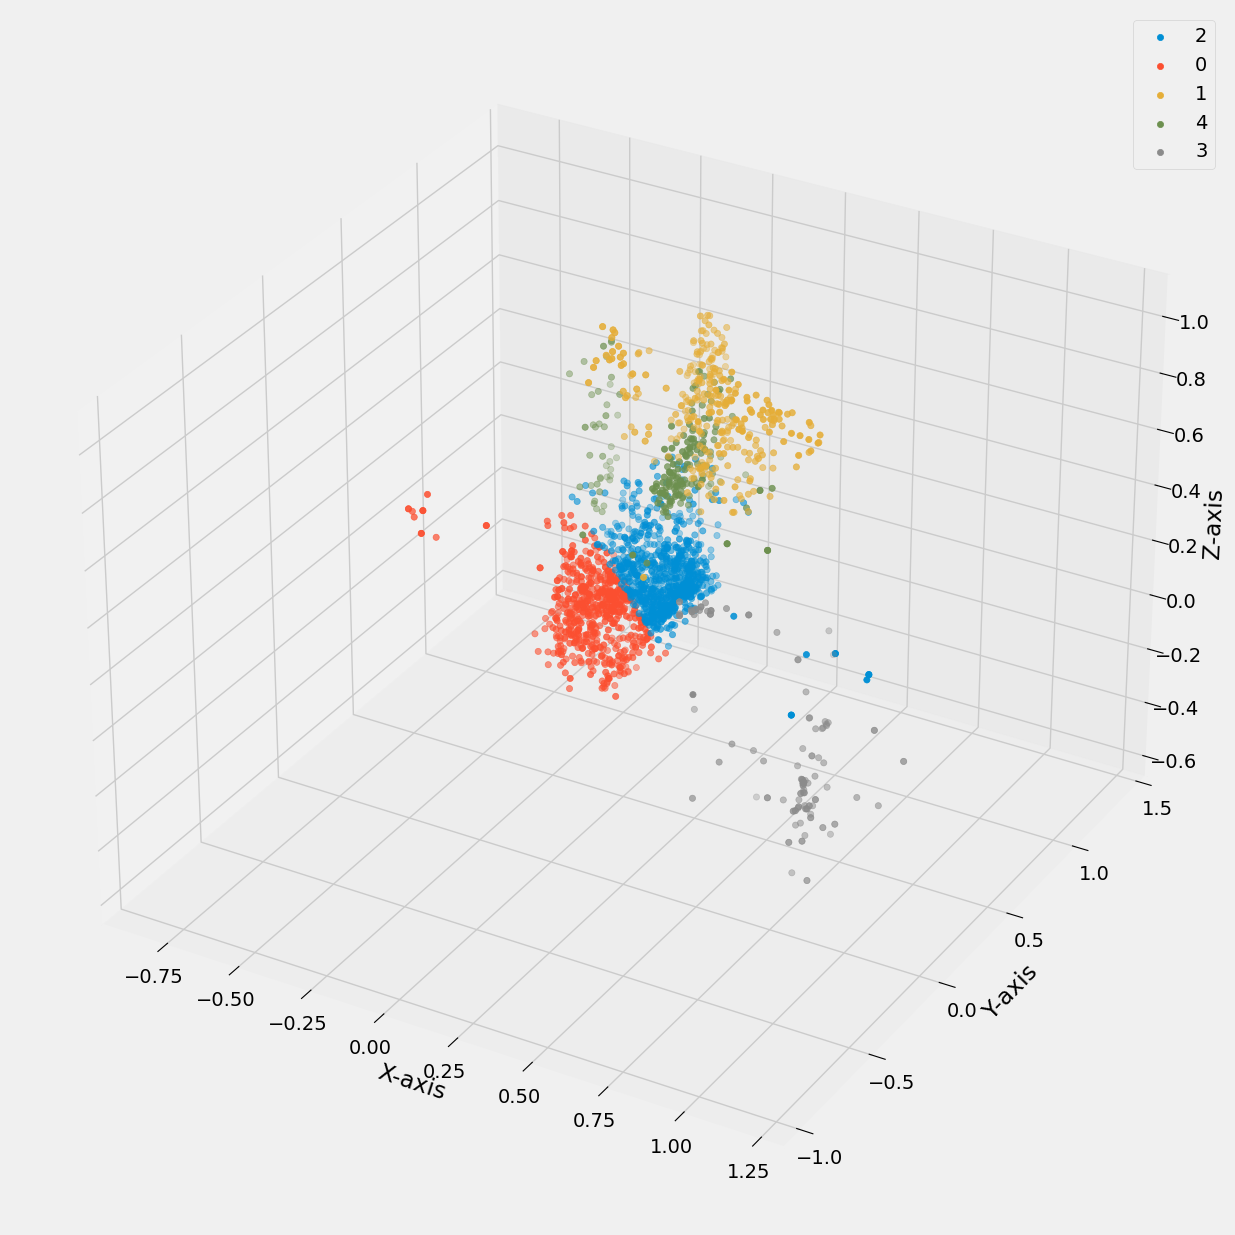

In [41]:
# Plot Clusters
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

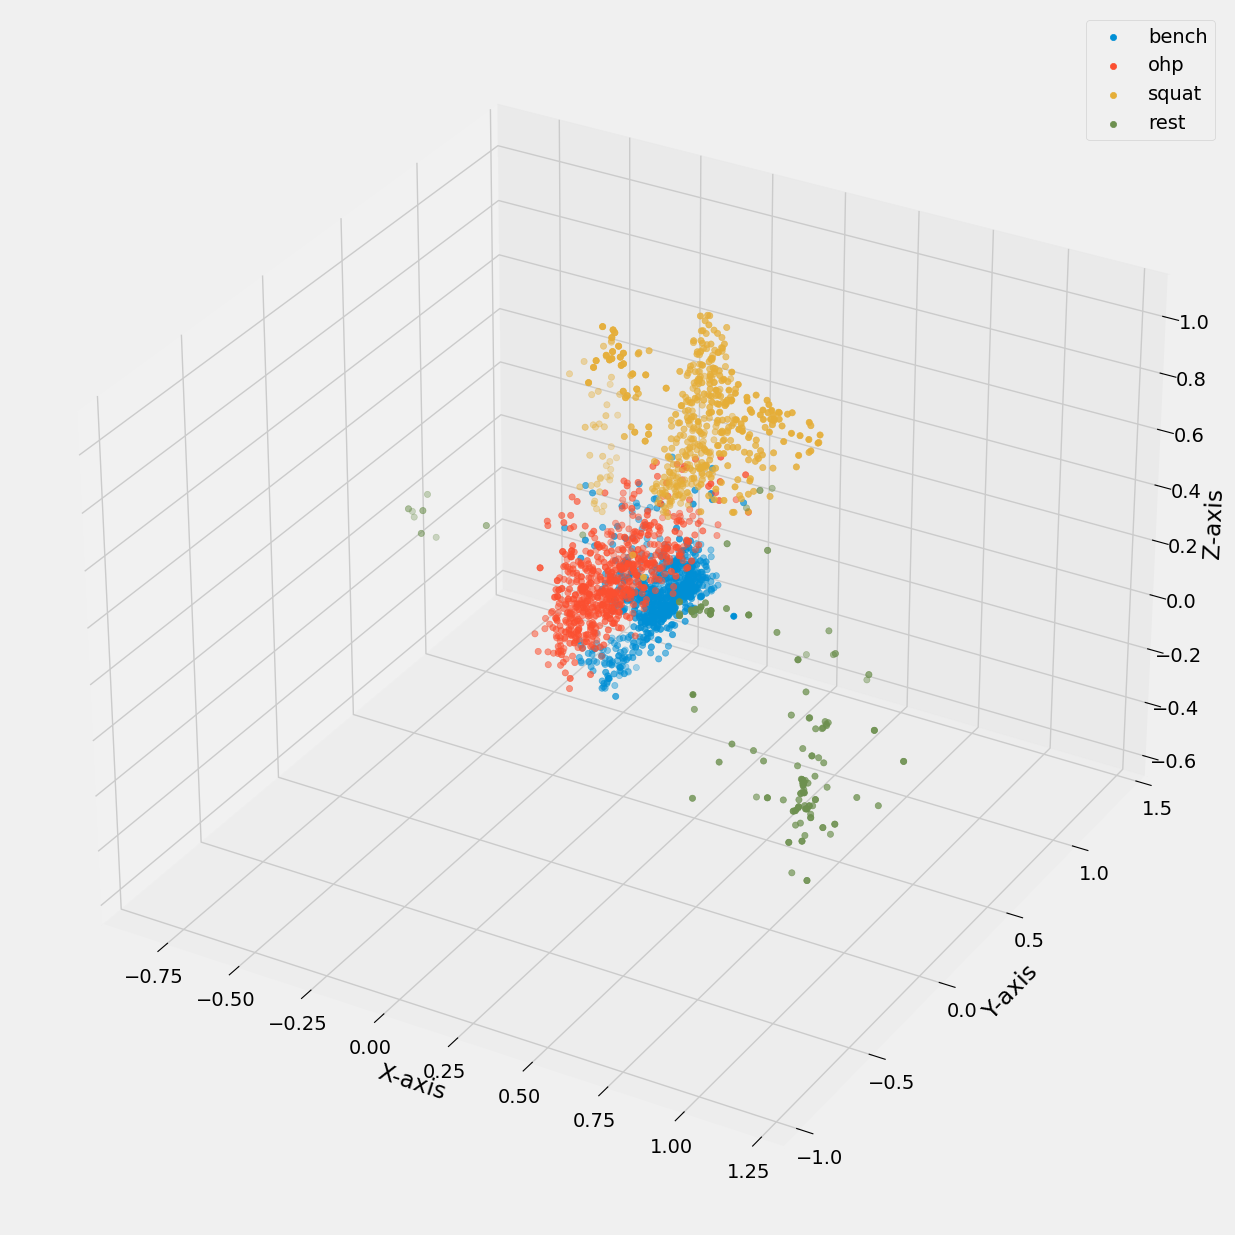

In [42]:
# Plot accelerometer data to compare
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=l)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()


In [43]:
joblib.dump(df_cluster, "data/03_feature_engineering.joblib")

['data/03_feature_engineering.joblib']